In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.stats import zscore, ttest_ind, f_oneway, mannwhitneyu
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score, 
                              ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.model_selection import train_test_split
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import label_binarize


sys.path.append("/projects/b1198/epifluidlab/ravi/0130/headneck/scripts")
from loaders import HNSCCFeatureHandler

/home/myt8099/.conda/envs/bert/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

METADATA_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/metadata/RAW_HNSCC_METADATA.csv"
VALID_IDS_PATH = "/projects/b1198/epifluidlab/ravi/0130/headneck/notebooks/lists/valid_ids.txt"
COVERAGE_DIR = '/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed'
hc_data = HNSCCFeatureHandler(METADATA_PATH, VALID_IDS_PATH)
_ = hc_data.load_feature_to_dataframe("/projects/b1198/epifluidlab/ravi/0130/headneck/data/hg38_frag_filtered/*.hg38.frag.delfi.bed", 1, 12)
t = hc_data.normalize_zscore()
m = hc_data.merge_feature_metadata()

scaler=StandardScaler()
raw_data = hc_data.get_raw_features()
institute = hc_data.get_metadata_col("Institute")

X = raw_data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)  
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = X.index
pca_df['Institute'] = institute
pca_df['Institute'] = pca_df['Institute'] == 1
unique_institutes = pca_df['Institute'].unique()
colors = sns.color_palette("tab10", len(unique_institutes))
color_map = {institute: colors[i] for i, institute in enumerate(unique_institutes)}
clf = LogisticRegression()
clf.fit(pca_df[['PC1', 'PC2']], pca_df['Institute'])
decision_boundary_y = -(clf.coef_[0][0] * pca_df['PC1'] + clf.intercept_[0]) / clf.coef_[0][1]
pca_df['institute_corrected'] = pca_df['PC2'] > decision_boundary_y
hc_data.metadata['Institute_Corrected']=pca_df['institute_corrected']

raw_data = hc_data.get_raw_features()
pilot = hc_data.get_metadata_col("Pilot")

X = raw_data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)  
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.index = X.index
pca_df['Pilot'] = pilot
pca_df['Pilot'] = pca_df['Pilot'] == 1
unique_pilots = pca_df['Pilot'].unique()
colors = sns.color_palette("tab10", len(unique_pilots))
color_map = {pilot: colors[i] for i, pilot in enumerate(unique_pilots)}
clf = LogisticRegression()
clf.fit(pca_df[['PC1', 'PC2']], pca_df['Pilot'])
decision_boundary_y = -(clf.coef_[0][0] * pca_df['PC1'] + clf.intercept_[0]) / clf.coef_[0][1]
pca_df['pilot_corrected'] = pca_df['PC2'] > decision_boundary_y
hc_data.metadata['Pilot_Corrected']=pca_df['pilot_corrected']

hc_data.merge_feature_metadata()["Institute_Corrected"]
hc_data.batch_correct()
raw_data = hc_data.get_raw_features()
#_ = hc_data.normalize_zscore()

In [3]:
K = 100

In [4]:
train_ids = list(hc_data.institute1_ids) + list(hc_data.institute2_ids) + list(hc_data.institute3_ids) + list(hc_data.institute4_ids)
test_ids = list(hc_data.institute5_ids) + list(hc_data.institute6_ids)
final_patient_df_train = hc_data.get_raw_features(hc_data.get_subset(train_ids))
final_patient_df_train_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(train_ids))
final_patient_df_train = pd.concat([final_patient_df_train, final_patient_df_train_metadata], axis=1)
final_patient_df_test = hc_data.get_raw_features(hc_data.get_subset(test_ids))
final_patient_df_test_metadata = hc_data.get_metadata_col("Treatment Response", hc_data.get_subset(test_ids))
final_patient_df_test = pd.concat([final_patient_df_test, final_patient_df_test_metadata], axis=1)
final_patient_df_combined= hc_data.get_raw_features()
final_patient_df_combined_metadata = hc_data.get_metadata_col("Treatment Response")
final_patient_df_combined = pd.concat([final_patient_df_combined, final_patient_df_combined_metadata], axis=1)
X_train = final_patient_df_train.iloc[:, :-1]
y_train = final_patient_df_train.iloc[:, -1]
X_test = final_patient_df_test.iloc[:, :-1]
y_test = final_patient_df_test.iloc[:, -1]
X_combined = final_patient_df_combined.iloc[:, :-1] 
y_combined = final_patient_df_combined.iloc[:, -1] 
y_train = y_train.astype(str)
y_test = y_test.astype(str)
y_combined = y_combined.astype(str)
selector = SelectKBest(f_classif, k=K)
X_new = selector.fit_transform(X_train, y_train)
selected_columns = X_train.columns[selector.get_support()]
X_train = pd.DataFrame(X_train, columns=selected_columns, index=X_train.index)
X_train['Treatment Response']=y_train
X_test = pd.DataFrame(X_test, columns=selected_columns, index=X_test.index)
X_test['Treatment Response']=y_test
X_combined = pd.DataFrame(X_combined, columns=selected_columns, index=X_combined.index)
X_combined['Treatment Response']=y_combined

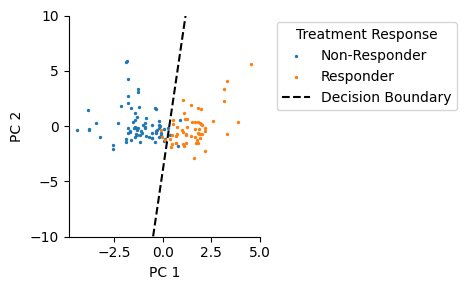

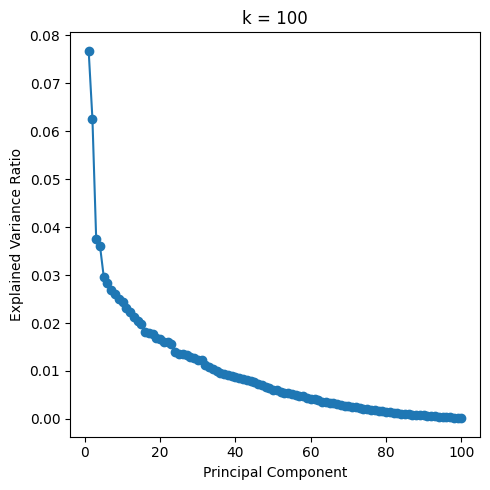

In [11]:
# Extract features for PCA
X = X_train.iloc[:, :-1]

# Perform PCA without setting n_components
pca = PCA()
pca_train_result = pca.fit_transform(X)
pca_train_df = pd.DataFrame(pca_train_result[:, :2], columns=['PC1', 'PC2'])
pca_train_df.index = X.index
pca_train_df['Treatment Response'] = X_train['Treatment Response']

# Assign colors
unique_treatments = pca_train_df['Treatment Response'].unique()
colors = sns.color_palette("tab10", len(unique_treatments))
color_map = {treatment: colors[i] for i, treatment in enumerate(unique_treatments)}

# Train Logistic Regression
clf = LogisticRegression()
clf.fit(pca_train_df[['PC1', 'PC2']], pca_train_df['Treatment Response'])

# Decision Boundary
x_values = np.linspace(pca_train_df['PC1'].min(), pca_train_df['PC1'].max(), 100)
y_values = -(clf.coef_[0][0] * x_values + clf.intercept_[0]) / clf.coef_[0][1]

# Plot PCA Scatter and Decision Boundary
plt.figure(figsize=(5, 3))
for treatment, color in color_map.items():
    subset = pca_train_df[pca_train_df['Treatment Response'] == treatment]
    plt.scatter(subset['PC1'], subset['PC2'], color=color, label=treatment, s=2)

plt.plot(x_values, y_values, 'k--', label="Decision Boundary")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylim(-10, 10)
plt.legend(title='Treatment Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig(f"{K}_PCA_train_Decision_Boundary.png", dpi=1000)
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title(f'k = {K}')
#plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.tight_layout()
plt.savefig(f"{K}_PCA_Scree_Plot.png", dpi=1000)
plt.show()


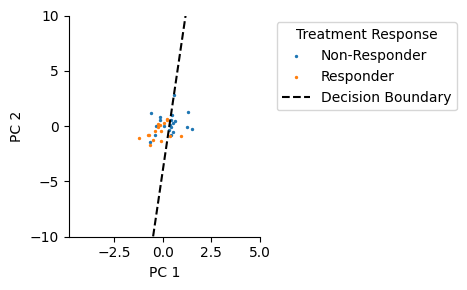

In [12]:
X = X_test.iloc[:,:-1]
pca_test_result = pca.transform(X)
pca_test_df = pd.DataFrame(pca_test_result[:, :2], columns=['PC1', 'PC2'])
pca_test_df.index = X.index
pca_test_df['Treatment Response'] = X_test['Treatment Response']

plt.figure(figsize=(5, 3))
for institute_l, color in color_map.items():
    subset = pca_test_df[pca_test_df['Treatment Response'] == institute_l]
    plt.scatter(subset['PC1'], subset['PC2'], color=color, label=institute_l, s=2)

plt.plot(x_values, y_values, 'k--', label="Decision Boundary")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylim(-10, 10)
plt.legend(title='Treatment Response', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.xticks([])
#plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout()
plt.savefig(f"{K}_PCA_Test_Decision_Boundary.png", dpi=1000)
plt.show()

In [13]:
clf = LogisticRegression()
clf.fit(X_train.iloc[:, :-1], X_train['Treatment Response'])

LogisticRegression()

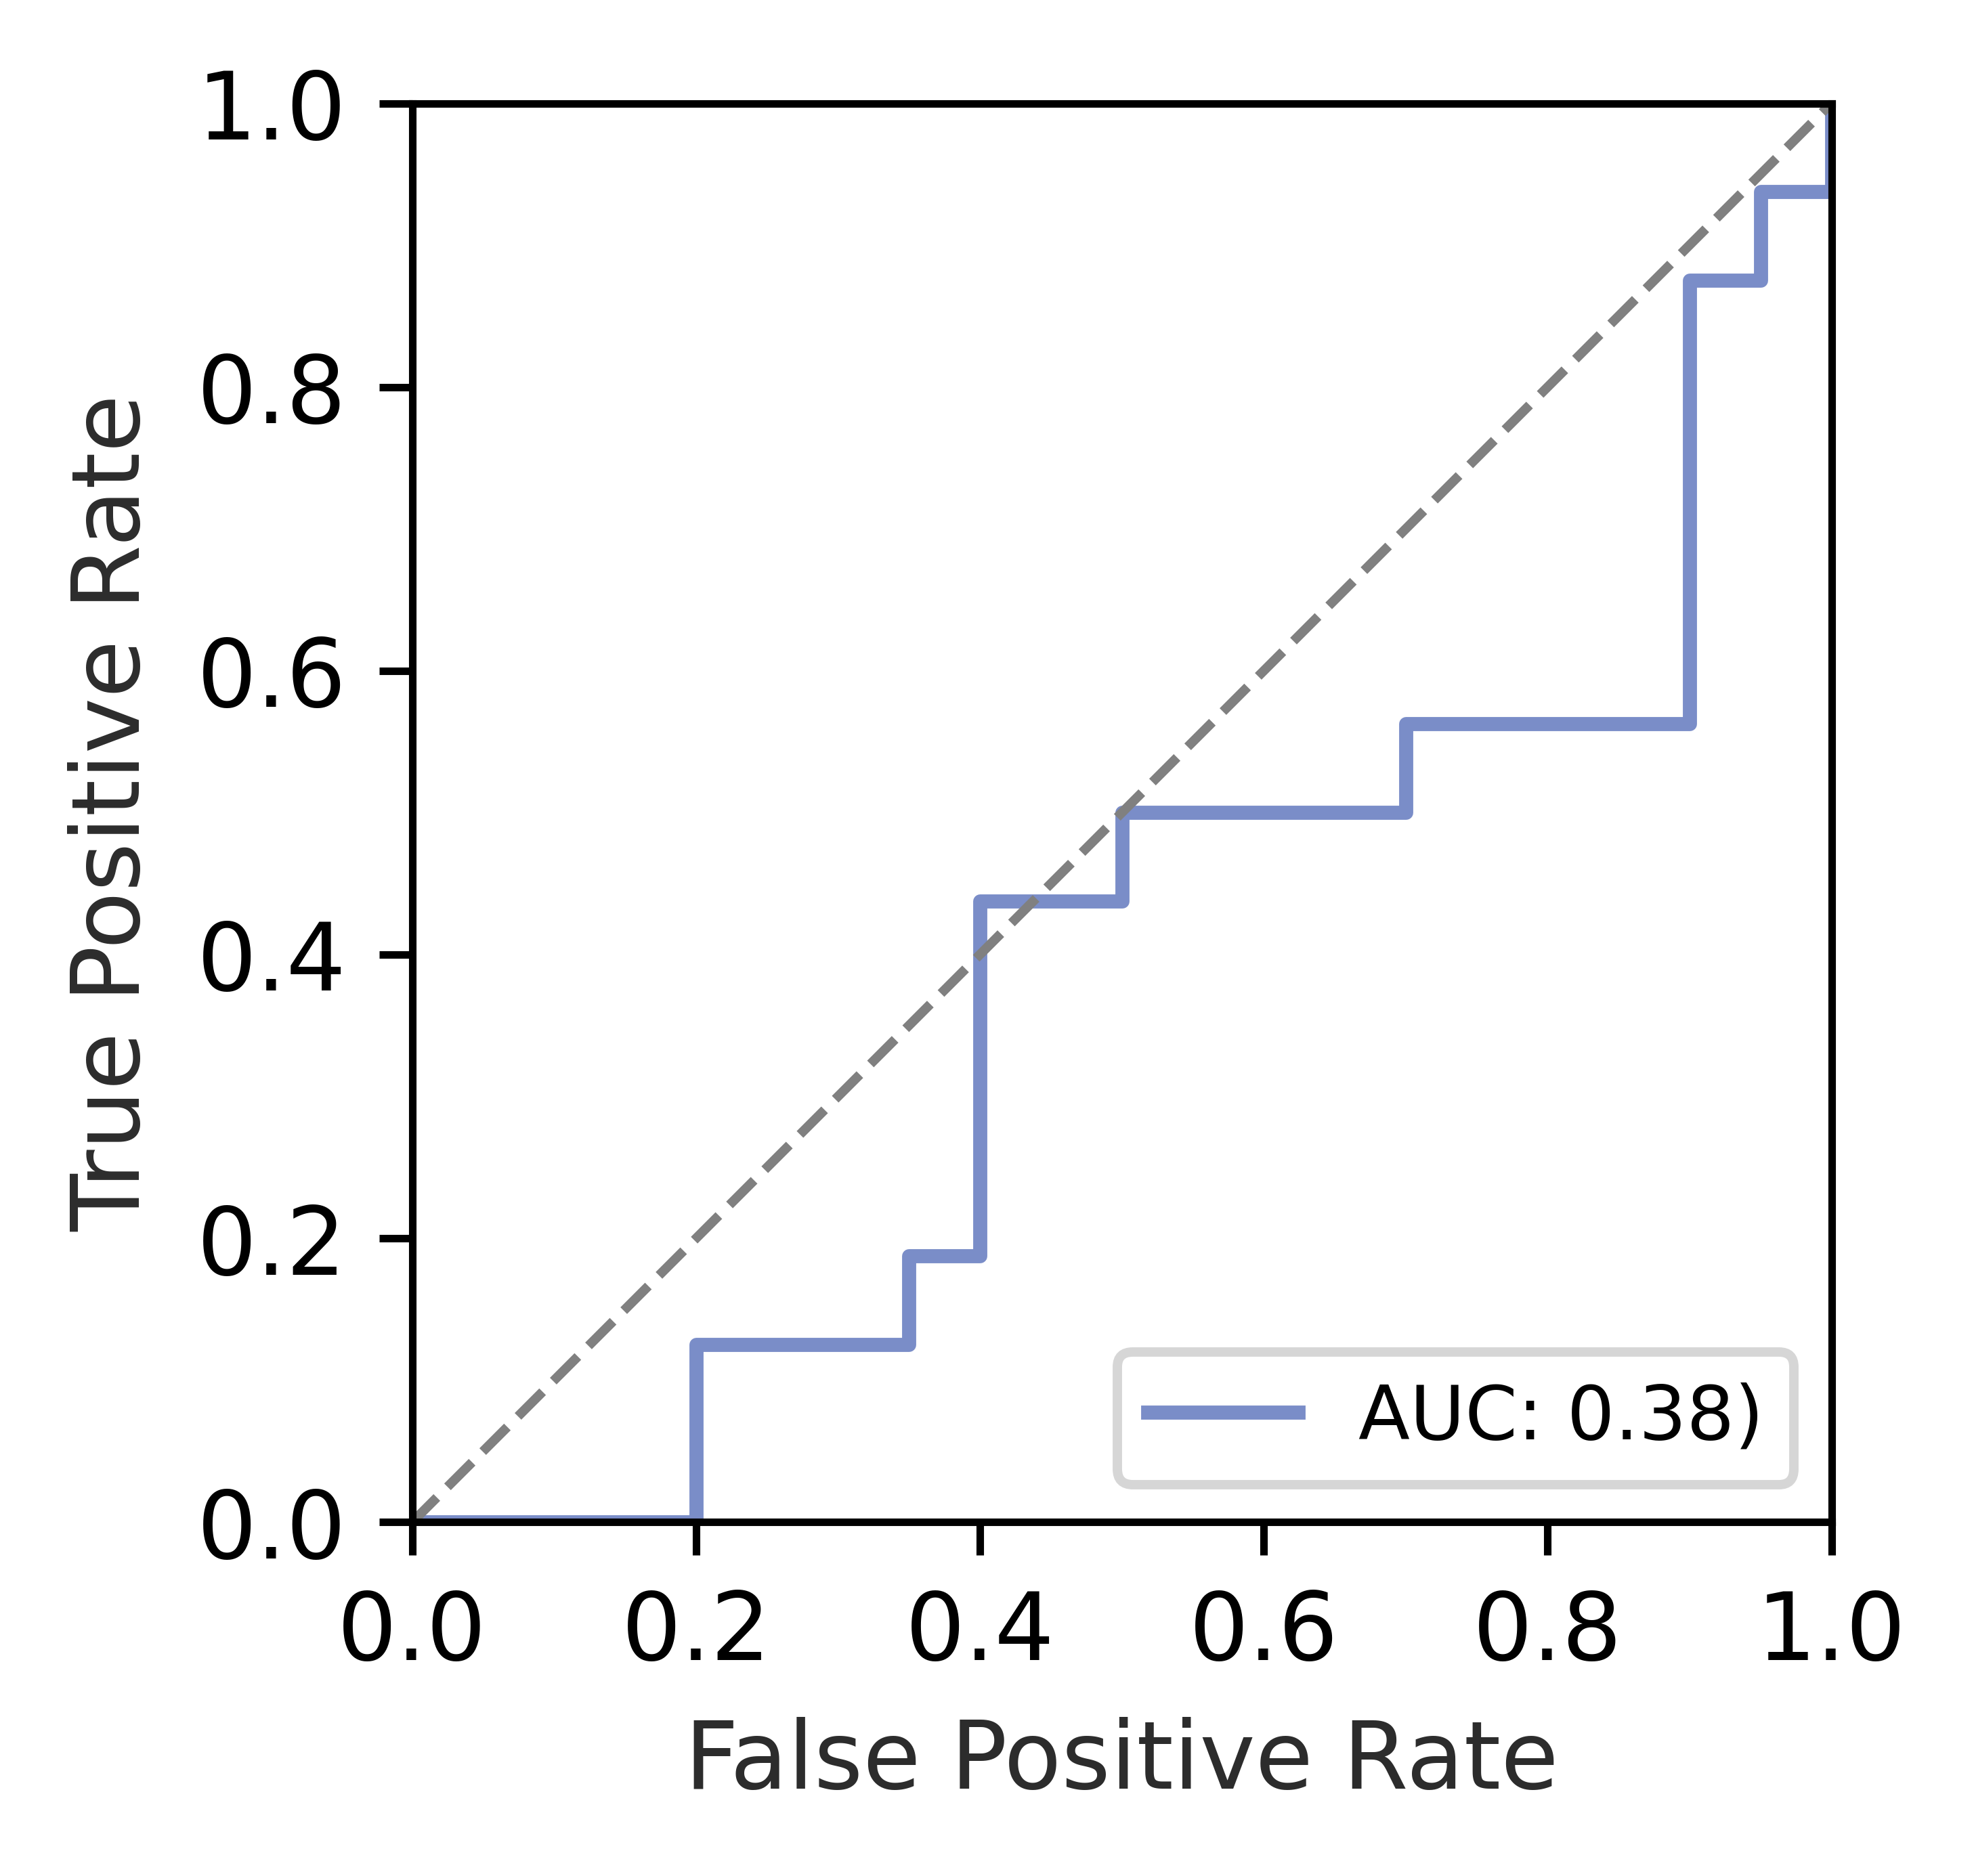

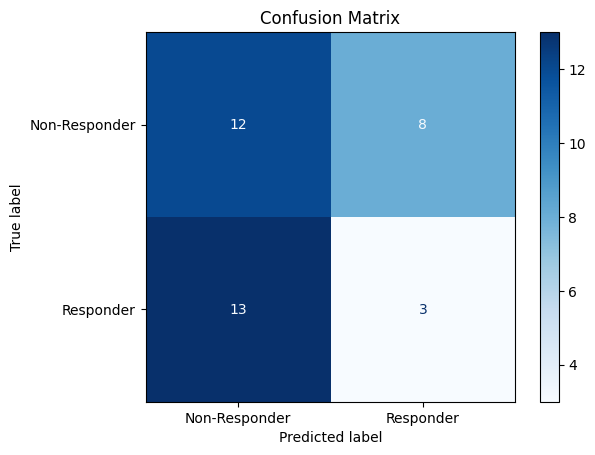

Balanced Accuracy: 0.3937


In [14]:
y_pred_proba = clf.predict_proba(X_test.iloc[:, :-1])

y_true = X_test['Treatment Response']

roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1], average='macro', multi_class='ovr')

# Plot ROC curve for each class
plt.figure(figsize=(3, 3), dpi=1000)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1], pos_label="Responder")
plt.plot(fpr, tpr, color=(122/255, 141/255, 200/255), lw=1.5, label=f'AUC: {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=10, color=(44/255, 44/255, 44/255))
plt.ylabel('True Positive Rate', fontsize=10, color=(44/255, 44/255, 44/255))
plt.legend(loc='lower right', fontsize=8)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig(f"{K}_PCA_BASELINE_ROC.png")
plt.show()
# Confusion Matrix
y_pred = clf.predict(X_test.iloc[:, :-1])
conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_treatments)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=unique_treatments)
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.savefig(f"{K}_PCA_BASELINE_CM.png")
plt.show()

balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')